# Data Ninja - Secret places to open a restaurant

**Fernanda Oliveira**  
Data Scientist

## Table of contents
1. [Introduction](#introduction)
2. [Data acquisition](#data)
3. [Methodology](#methodology)
4. [Analysis](#Analysis)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)

## 1. Introduction  <a name="introduction"></a>

### 1.1 Background

The city of Berlin is well known to be a cosmopolitan city where you can find people from all around the world. Berlin offers a very wide commercial variety, especially in the area of gastronomy. The trend that comes to stay, are Asian restaurants, particularly Japanese restaurants. Although there are a lot of them spread in the city, there are new ones opening all the time. Therefore to analyze locations, types, and the number of these restaurants is a plus for those who want to open a new restaurant in the city.

### 1.2 Problem

Searching an optimal location to open a Japanese restaurant in the city of Berlin can be challenging. One could think that the better location for it should be at a place where there is no Japanese restaurant. But the problem is that perhaps most of the interested customers instead of going to an isolated neighborhood, prefer to go to a popular neighborhood, where there are more options and also there is movement of people. At the same time that the concurrence will be big in these regions, the flux of interested customers in this specific region will be relevant as well. Many people, for example, go on the weekends to a specific Japanese restaurant and when they arrive, there is a large line waiting for them. This usually happens because it is also a new trend in Berlin, in some popular restaurants, not to have an option to make a reservation. The good news is that perhaps some of the customers, those who do not want wait too long in line, might want to search for similar options in the neighborhood. 

### 1.3 Interest

This project is ideal for a person or a branch that is interested in opening a Japanese restaurant. 

First I will import the libraries necessary for this project.

In [1]:
import geocoder
from geopy.geocoders import Nominatim
#!pip install pygeocoder
from pygeocoder import Geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Data acquisition <a name="Data source "></a>

### 2.1 Data source 

The data and tools that I will use are the following:

* **Foursquare API** to select the number of restaurants and their location in some neighborhoods of Berlin
* **Geocoder** to get the latitudes and longitudes of places to rent, together with information from https://www.sebuyo.com

### 2.2 Feature selection

* I will first create a dataset thought the Foursquare API, exploring several types of venues, such as, ID, name, category (Japanese restaurant), latitude, longitude, neighborhood and distance (in meters) to Charllotenburg, a borough of Berlin, where is very famous to have Japanese restaurants. Then I will apply again the search using Foursquare API for the public transportation categories, city train and metro in Berlin. 

* I will save the data collected using Fousquare API to a CSV file and then read them with `Pandas`.

* Then, I will create another dataset that has information about avaiable places to rent in Berlin. First, I will create the features "postal codes" and "prices" of these places and then with the help of Geocoder we will get the latitude, longitude features. Then, I will save to a file CSV and read it with `Pandas`.


In [72]:
CLIENT_ID = 'myclientID' # your Foursquare ID
CLIENT_SECRET = 'myclientsecret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: myclientID
CLIENT_SECRET:myclientsecret


In [3]:
# define Berlin's geolocation coordinates (center of Charllotenburg)
berlin_latitude = 52.50333132 #52.520008
berlin_longitude = 13.308665432 #13.404954

In [4]:
# type your answer here
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 15000 # define radius
category = '4bf58dd8d48988d111941735' # Japanese restaurants 
#category = '4bf58dd8d48988d1fc931735' # S-Bahnhof
#category = '4bf58dd8d48988d1fd931735' #U-Bahnhof

In [5]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
 CLIENT_ID, 
   CLIENT_SECRET, 
    VERSION, 
   berlin_latitude, 
   berlin_longitude, 
    category,
      radius, 
    LIMIT)

In [6]:
results = requests.get(url).json()
results.values();

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
venues = results['response']['groups'][0]['items']
venues_neighborhood = [results['response']['groups'][0]['items'][n]['venue']['location']['formattedAddress'] for n in range(len(venues))]  
venues_distance = [results['response']['groups'][0]['items'][n]['venue']['location']['distance'] for n in range(len(venues))]  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

[venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]

#nearby_venues['neighborhood'] = venues_neighborhood[0][0]
nearby_venues['neighborhood'] =  [venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]
nearby_venues['distance [m]'] = venues_distance

df = nearby_venues
df.head()

,id,name,categories,lat,lng,neighborhood,distance [m]
0,55f9a48e498ee737a1893058,Heno Heno,Japanese Restaurant,52.503964,13.315578,Wielandstr. 37,473
1,4bbe353b9474c9b63e41d9b6,Kushinoya,Japanese Restaurant,52.505372,13.319982,Bleibtreustr. 6,799
2,570b97c4498e2c6e7c5eb991,Smart Deli,Japanese Restaurant,52.528094,13.389060,Novalisstr. 2,6103
3,57c9e26a498ed1dcbbd0b461,Sticks'n'Sushi,Japanese Restaurant,52.502020,13.365064,Potsdamer Str. 85,3824
4,4c0fde34ce57c928f7f580d2,Green Tea Café MAMECHA,Japanese Restaurant,52.527284,13.406305,Mulackstr. 33 (Rückerstr.),7131


In [9]:
#import os

#outname = 'japanesecategory.csv'

#outdir = '/'
#if not os.path.exists(outdir):
 #   os.mkdir(outdir)

#fullname = os.path.join(outdir, outname)    

#df.to_csv(fullname)

In [10]:
df_jc = pd.read_csv("japanesecategory.csv")
df_jc.drop(['Unnamed: 0'], axis=1, inplace=True);
df_jc.drop(['distance [m]'], axis=1, inplace=True);
df_jc.head()

,id,name,categories,lat,lng,neighborhood
0,55f9a48e498ee737a1893058,Heno Heno,Japanese Restaurant,52.503964,13.315578,Wielandstr. 37
1,4bbe353b9474c9b63e41d9b6,Kushinoya,Japanese Restaurant,52.505372,13.319982,Bleibtreustr. 6
2,570b97c4498e2c6e7c5eb991,Smart Deli,Japanese Restaurant,52.528094,13.389060,Novalisstr. 2
3,57c9e26a498ed1dcbbd0b461,Sticks'n'Sushi,Japanese Restaurant,52.502020,13.365064,Potsdamer Str. 85
4,4c0fde34ce57c928f7f580d2,Green Tea Café MAMECHA,Japanese Restaurant,52.527284,13.406305,Mulackstr. 33 (Rückerstr.)


In [11]:
df_s = pd.read_csv("sbahncategory.csv")
df_s.drop(['Unnamed: 0'], axis=1, inplace=True);
df_s.drop(['distance [m]'], axis=1, inplace=True);
df_s.head()

,id,name,categories,lat,lng,neighborhood
0,4a1c8506f964a520457b1fe3,Berlin Hauptbahnhof,Light Rail Station,52.525220,13.369369,Europaplatz 1 (Washingtonplatz)
1,4af5f0c7f964a52020ff21e3,Bahnhof Berlin Friedrichstraße,Light Rail Station,52.520284,13.387063,Georgenstr. 14/17
2,4b05bf38f964a5204ce222e3,Bahnhof Berlin Potsdamer Platz,Light Rail Station,52.509723,13.376597,Potsdamer Platz (Potsdamer Str.)
3,4adcda91f964a520ba4b21e3,Bahnhof Berlin Zoologischer Garten,Light Rail Station,52.506642,13.332513,Hardenbergplatz 13
4,4b01859ef964a520174322e3,S Savignyplatz,Light Rail Station,52.505093,13.319847,Bleibtreustr. 49


In [12]:
df_u = pd.read_csv("ubahn_data.csv")
df_u.drop(['Unnamed: 0'], axis=1, inplace=True);
df_u.drop(['distance [m]'], axis=1, inplace=True);
df_u.head()

,id,name,categories,lat,lng,neighborhood
0,4bfb2cf765fbc9b66f23916c,U Rehberge,Metro Station,52.555570,13.343412,Müllerstr. (Dubliner Str.)
1,4b538a1af964a52043a127e3,U Wilmersdorfer Straße,Metro Station,52.506312,13.306770,Wilmersdorfer Str. (Kantstr.)
2,4b5de986f964a520387329e3,U Adenauerplatz,Metro Station,52.499950,13.307203,Adenauerplatz (Kurfürstendamm)
3,4b47845cf964a5209e3426e3,U Güntzelstraße,Metro Station,52.490989,13.330868,Bundesallee (Güntzelstr.)
4,4b2a3edbf964a52076a624e3,U Deutsche Oper,Metro Station,52.511193,13.311905,Bismarckstr. (Krumme Str./Weimarer Str.)


Using the website https://www.sebuyo.com I made a search of prices and code postal of the avaiable places to rent in Berlin

In [13]:
df_rent = pd.DataFrame({'Postcode': [10247, 10777, 10713, 10719, 12359, 12057, 10785, 12043, 13595, 12053, 10435, 10119, 10245, 13597, 12347, 10115, 10717, 13585, 12057, 16727],'Price': [2400, 1142.36, 3269, 5900, 300, 400, 3900, 10000, 0, 1600, 2500, 3000, 1095, 0, 1000, 0, 2700, 570, 400, 0]})

In [14]:
df_rent.head()

,Postcode,Price
0,10247,2400.00
1,10777,1142.36
2,10713,3269.00
3,10719,5900.00
4,12359,300.00


Using Geocoder I found the respectivelly latitudes and longitudes using the information of the code postal. 

In [15]:
def  get_latlng(postal_code):
    latlng_coords = None
    while(latlng_coords is None):
        g = geocoder.arcgis('{}, Berlin, Berlin'.format(postal_code))
        latlng_coords = g.latlng
    return latlng_coords

In [16]:
codepost = df_rent['Postcode']
coords = [get_latlng(postal_code) 
         for postal_code 
         in codepost.tolist()]

In [17]:
df_coords = pd.DataFrame(coords, columns = ['Latitude', 'Longitude'])
df_rent['Latitude'] = df_coords['Latitude']
df_rent['Longitude'] = df_coords['Longitude']

Here I saved the dataframe df_rent to a file and then I read with pandas.

In [18]:
df_r = pd.read_csv("rent_data.csv")
df_r.drop(['Unnamed: 0'], axis=1, inplace=True);
df_r.head()

,Postcode,Price,Latitude,Longitude
0,12683,2900.00,52.503731,13.559540
1,10247,2400.00,52.516340,13.463990
2,10777,1142.36,52.497685,13.342285
3,10713,3269.00,52.485240,13.311870
4,10719,5900.00,52.498245,13.327140


Here we will understand more our data collection and we will apply some descriptive statistics to answer to following answers:

* How many restaurants exists?
* How many avaiable places to rent exist?
* How many categories exist in each dataset?

In [19]:
df_jc['categories'].describe()

count                     100
unique                     10
top       Japanese Restaurant
freq                       63
Name: categories, dtype: object

In [20]:
df_jc.categories.unique()

array(['Japanese Restaurant', 'Vietnamese Restaurant', 'Sushi Restaurant',
       'Ramen Restaurant', 'Asian Restaurant', 'Chinese Restaurant',
       'Café', 'Vegetarian / Vegan Restaurant', 'Korean Restaurant',
       'Cocktail Bar'], dtype=object)

In [21]:
df_r.count()

Postcode     21
Price        21
Latitude     21
Longitude    21
dtype: int64

Text(0, 0.5, 'frequency')

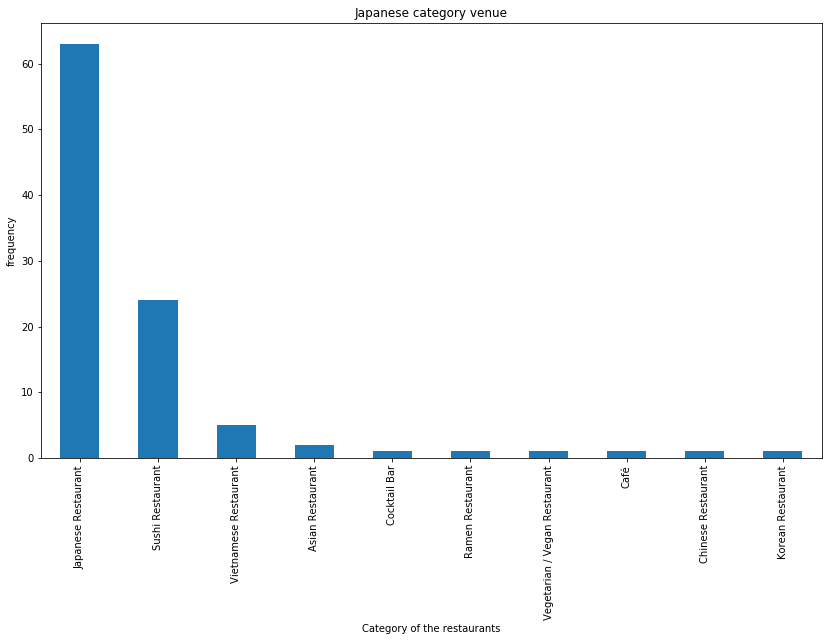

In [22]:
ax = df_jc['categories'].value_counts().plot(kind='bar', figsize=(14,8), title="Japanese category venue")
ax.set_xlabel("Category of the restaurants")
ax.set_ylabel("frequency")

## 3. Methodology

The goal of this project is to search for locations where the neighborhood is surrounded by Japanese restaurants. Then I will apply the Machine Learning algorithms **K-means Clustering** for to make segmentations of the types of Japanese restaurants. After that, a research about the prices to rent a place for opening a restaurant will be made. In addition, the optimal location should be accessible by public transportation. At the end, the focus will be to find locations that have a distance of approximately 300 m from Japanese restaurants that already exists and near of public transportations. 
 Based on the goal of this project, I will describe below, what is needed to perform this search and which data sources will be used:
 
* number of existing Japanese restaurants
* prices and locations of places in Berlin to open a restaurant
* segmentation of types of Japanese restaurants in a neighborhood
* distance of the available places to rent to the Japanese restaurants that already exists and to the public transportation.

K-means Clustering is a simple and popular unsupervised algorithms that can be used to make segmentations. Segmentation is a practice of divide a feature into groups with similar characteristics. Therefore one can get some insights about the characteristics of the data. 

First, I will start applying the **One-hot Encoding** function to convert categorical variations to numerical ones. This facilitated for Machine Learning algorithms to better prediction.  The results 0 indicates non existent while 1 indicates existent.

In [23]:
# one hot encoding for Japanese category
berlin_onehot = pd.get_dummies(df_jc[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['neighborhood'] = df_jc['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]
berlin_grouped = berlin_onehot.groupby('neighborhood').mean().reset_index()

In [24]:
berlin_onehot.head()

,neighborhood,Asian Restaurant,Café,Chinese Restaurant,Cocktail Bar,Japanese Restaurant,Korean Restaurant,Ramen Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Wielandstr. 37,0,0,0,0,1,0,0,0,0,0
1,Bleibtreustr. 6,0,0,0,0,1,0,0,0,0,0
2,Novalisstr. 2,0,0,0,0,1,0,0,0,0,0
3,Potsdamer Str. 85,0,0,0,0,1,0,0,0,0,0
4,Mulackstr. 33 (Rückerstr.),0,0,0,0,1,0,0,0,0,0


In [25]:
berlin_grouped = berlin_onehot.groupby('neighborhood').mean().reset_index()

Now I want create a dataframe in `Pandas`. For this I will use a function to sort the venues in descending order.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    

Here I will create a new dataframe and display the top 7 venues for each neighborhood.

In [27]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = berlin_grouped['neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

In [28]:
neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Ahornstr. 32,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
1,Albrechtstr. 131,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
2,Alte Schönhauser Str. 13 (Mulackstr.),Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
3,Alte Schönhauser Str. 7-8,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
4,Bergmannstraße 93,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar


### 3.1 Cluster Neighborhoods

I will run *k*-means to cluster the neighborhood into 5 clusters.

In [29]:
# set number of clusters
kclusters = 5

berlin_grouped_clustering = berlin_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 2, 1, 2, 2, 2, 2], dtype=int32)

In [30]:
kmeans_cluster_centers = kmeans.cluster_centers_
kmeans_cluster_centers.shape

(5, 10)

In [31]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

In [32]:
neighborhoods_venues_sorted.head()

,Cluster Labels,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,0,Ahornstr. 32,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
1,0,Albrechtstr. 131,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
2,2,Alte Schönhauser Str. 13 (Mulackstr.),Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
3,2,Alte Schönhauser Str. 7-8,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
4,2,Bergmannstraße 93,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar


In [33]:
df_jc.head()

,id,name,categories,lat,lng,neighborhood
0,55f9a48e498ee737a1893058,Heno Heno,Japanese Restaurant,52.503964,13.315578,Wielandstr. 37
1,4bbe353b9474c9b63e41d9b6,Kushinoya,Japanese Restaurant,52.505372,13.319982,Bleibtreustr. 6
2,570b97c4498e2c6e7c5eb991,Smart Deli,Japanese Restaurant,52.528094,13.389060,Novalisstr. 2
3,57c9e26a498ed1dcbbd0b461,Sticks'n'Sushi,Japanese Restaurant,52.502020,13.365064,Potsdamer Str. 85
4,4c0fde34ce57c928f7f580d2,Green Tea Café MAMECHA,Japanese Restaurant,52.527284,13.406305,Mulackstr. 33 (Rückerstr.)


In [34]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

berlin_merged = df_jc

# merge berlin_grouped with berlin_data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')
berlin_merged.head() # check the last columns!

,id,name,categories,lat,lng,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,55f9a48e498ee737a1893058,Heno Heno,Japanese Restaurant,52.503964,13.315578,Wielandstr. 37,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
1,4bbe353b9474c9b63e41d9b6,Kushinoya,Japanese Restaurant,52.505372,13.319982,Bleibtreustr. 6,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
2,570b97c4498e2c6e7c5eb991,Smart Deli,Japanese Restaurant,52.528094,13.389060,Novalisstr. 2,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
3,57c9e26a498ed1dcbbd0b461,Sticks'n'Sushi,Japanese Restaurant,52.502020,13.365064,Potsdamer Str. 85,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
4,4c0fde34ce57c928f7f580d2,Green Tea Café MAMECHA,Japanese Restaurant,52.527284,13.406305,Mulackstr. 33 (Rückerstr.),2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar


## 4. Analysis  <a name="Analysis"></a>

Now that we applied the **K-mean Clustering**, we will analise each cluster creating datasets for each of them. 

### Cluster 0

In [35]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]].head()

,id,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
28,4b3ba703f964a5200a7825e3,Kottbusser Damm 102,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
48,4d358f7f2c76a1438bd18fc7,Goethestr. 37-38,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
53,4adcda88f964a520724921e3,Albrechtstr. 131,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
54,5571f00e498e055a7d77700d,Dahlmannstr. 14,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
55,4c84d8ab51ada1cd472a3210,Wilmersdorfer Str. 22 (Thrasoltstr.),0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar


In [36]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 0].count()

24

In [37]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]].head()

,id,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
28,4b3ba703f964a5200a7825e3,Kottbusser Damm 102,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
48,4d358f7f2c76a1438bd18fc7,Goethestr. 37-38,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
53,4adcda88f964a520724921e3,Albrechtstr. 131,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
54,5571f00e498e055a7d77700d,Dahlmannstr. 14,0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
55,4c84d8ab51ada1cd472a3210,Wilmersdorfer Str. 22 (Thrasoltstr.),0,Sushi Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar


### Cluster 1

In [38]:
clusterone = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 1].count()

7

In [39]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
26,KUCHI Mitte,Gipsstr. 3 (Auguststr.),1,Ramen Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Korean Restaurant,Cocktail Bar
39,Cocolo Ramen,Gipsstr. 3 (Auguststr.),1,Ramen Restaurant,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Korean Restaurant,Cocktail Bar
68,Asia Land,Berlin,1,Chinese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant
72,Café Komine,Welserstr. 13-15 (Geisbeegerstr.),1,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant
85,Secret Garden Berlin,Wahrschauerstr. 32 (Helsingforser Str.),1,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
88,Seoulkitchen Korean BBQ & Sushi,Warschauer Str. 46 (Mühlenstr.),1,Korean Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Japanese Restaurant,Cocktail Bar
98,Bar Tausend,Schiffbauerdamm 11,1,Cocktail Bar,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant


### Cluster 2

In [40]:
clustertwo = berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

In [41]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 2].count()

62

In [42]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]].head()

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Heno Heno,Wielandstr. 37,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
1,Kushinoya,Bleibtreustr. 6,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
2,Smart Deli,Novalisstr. 2,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
3,Sticks'n'Sushi,Potsdamer Str. 85,2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar
4,Green Tea Café MAMECHA,Mulackstr. 33 (Rückerstr.),2,Japanese Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Cocktail Bar


### Cluster 3

In [43]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
27,DUDU,Torstr. 134,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
61,Sy Restaurant,Kantstr. 54,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
69,Mama Cook,Hedemannstraße 10,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
82,Eden Restaurant,Rosenstr. 19 (Rochstr.),3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
90,Minh-Trang,Kantstr. 67 (Kaiser-Friedrich-Str.),3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar


In [44]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 3].count()

5

In [45]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
27,DUDU,Torstr. 134,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
61,Sy Restaurant,Kantstr. 54,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
69,Mama Cook,Hedemannstraße 10,3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
82,Eden Restaurant,Rosenstr. 19 (Rochstr.),3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar
90,Minh-Trang,Kantstr. 67 (Kaiser-Friedrich-Str.),3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant,Cocktail Bar


### Cluster 4

In [46]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
44,893 Ryōtei,Kantstr. 135,4,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant
83,rice & more,Großbeerenstr. 51,4,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant


In [47]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 4].count()

2

In [48]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
44,893 Ryōtei,Kantstr. 135,4,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant
83,rice & more,Großbeerenstr. 51,4,Asian Restaurant,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Ramen Restaurant,Korean Restaurant,Japanese Restaurant


Here we will calculate the score of the available places to rent to the Japanese restaurants that already exists and to the public transportation.

In [49]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

In [50]:
X = list(berlin_merged['lat']);
Y = list(berlin_merged['lng']);
x, y = lonlat_to_xy(X, Y)
japanese_list = [(x[n],y[n]) for n in range(len(x))]
japanese_list;

In [51]:
X1 = list(df_r['Latitude']);
Y1 = list(df_r['Longitude']);
x1, y1 = lonlat_to_xy(X1, Y1)
rent_list = [(x1[n],y1[n]) for n in range(len(x1))]
rent_list;

In [52]:
X2 = list(df_s['lat']);
Y2 = list(df_s['lng']);
x2, y2 = lonlat_to_xy(X2, Y2)
sbahn_list = [(x2[n],y2[n]) for n in range(len(x2))]
sbahn_list;

In [53]:
X3 = list(df_u['lat']);
Y3 = list(df_u['lng']);
x3, y3 = lonlat_to_xy(X3, Y3)
ubahn_list = [(x3[n],y3[n]) for n in range(len(x3))]
ubahn_list;

In [54]:
optimal_list=[]

In [55]:
for place_to_rent in rent_list:
    distances_to_restaurants = [calc_xy_distance(place_to_rent[0], place_to_rent[1], jap[0], jap[1]) for jap in japanese_list]
    closest_restaurant = min(distances_to_restaurants)
    
    distances_to_transport = [calc_xy_distance(place_to_rent[0], place_to_rent[1], transp[0], transp[1]) for transp in sbahn_list]
    closest_transport = min(distances_to_transport)
    
    optimal_list.append((closest_transport)+abs(closest_restaurant - 300))

In [56]:
optimal_list;

In [57]:
df_optimal=pd.DataFrame(optimal_list,columns=['Score'])

In [58]:
df_optimal['Score'].head()

0    20580.636132
1     1491.643158
2     2027.250023
3     1353.984241
4     1390.663694
Name: Score, dtype: float64

In [59]:
df_r['Score'] = df_optimal['Score']
df_r.head()

,Postcode,Price,Latitude,Longitude,Score
0,12683,2900.00,52.503731,13.559540,20580.636132
1,10247,2400.00,52.516340,13.463990,1491.643158
2,10777,1142.36,52.497685,13.342285,2027.250023
3,10713,3269.00,52.485240,13.311870,1353.984241
4,10719,5900.00,52.498245,13.327140,1390.663694


In [60]:
df_address = pd.DataFrame({'Postcode': [12683, 10247, 10777, 10713, 10719, 12359, 12057, 10785, 12043, 13595, 12053, 10435, 10119, 10245, 13597, 12347, 10115, 10717, 13585, 12057, 16727],'Address': ['Wulkower Straße 10, Biesdorf', 'Silvio-Meier-Straße 8, Friedrichshain', 'Welserstraße 14D, Schöneberg', 'Barstraße, Wilmersdorf', 'Fasanenplatz, Wilmersdorf', 'Malchiner Straße 55, Britz', 'Sonnenallee 289, Neukölln', 'Stauffenbergstraße 1, Tiergarten', 'Donaustraße 94, Neukölln', 'Heerstraße 243, Pichelsdorf', 'Morusstraße 18A, Neukölln', 'Choriner Straße 49, Prenzlauer Berg', 'Zehdenicker Straße 21, Mitte', 'Corinthstraße 7, Friedrichshain', 'Kolonie Tiefwerder Brücke 1, Wilhelmstadt', 'Alpenhöhe (43 - 47a), Britz', 'Zinnowitzer Straße 2, Mitte', 'Trautenaustraße 14, Wilmersdorf', 'Neumeisterstraße 5, Neustadt', 'Sonnenallee 289, Neukölln', 'Ebertstraße, Mitte']})

In [61]:
df_address

,Postcode,Address
0,12683,"Wulkower Straße 10, Biesdorf"
1,10247,"Silvio-Meier-Straße 8, Friedrichshain"
2,10777,"Welserstraße 14D, Schöneberg"
3,10713,"Barstraße, Wilmersdorf"
4,10719,"Fasanenplatz, Wilmersdorf"
5,12359,"Malchiner Straße 55, Britz"
6,12057,"Sonnenallee 289, Neukölln"
7,10785,"Stauffenbergstraße 1, Tiergarten"
8,12043,"Donaustraße 94, Neukölln"
9,13595,"Heerstraße 243, Pichelsdorf"


In [62]:
df_r['Address'] = df_address['Address']

In [63]:
df_r = df_r.sort_values(by=['Score']).reset_index()

In [64]:
df_r.shape

(21, 7)

In [65]:
df_r = df_r.set_index('Address')

In [66]:
df_r.head()

,index,Postcode,Price,Latitude,Longitude,Score
Address,,,,,,
"Zinnowitzer Straße 2, Mitte",16,10115,0.0,52.531570,13.383444,748.154426
"Zehdenicker Straße 21, Mitte",12,10119,3000.0,52.530505,13.405483,1310.302883
"Barstraße, Wilmersdorf",3,10713,3269.0,52.485240,13.311870,1353.984241
"Ebertstraße, Mitte",20,16727,0.0,52.516040,13.376910,1382.880829
"Fasanenplatz, Wilmersdorf",4,10719,5900.0,52.498245,13.327140,1390.663694


## 5. Results and discussions  <a name="Results and discussions"></a>

In this section, I will show some of the results obtained. I segmented the category features into five Clusters and I can see the **1st Most Common Venue** in each of these clusters: 
* **cluster 0**: 24 Sushi restaurants 
* **cluster 1**: 2 Ramen, 1 Chinese, 1 vegetarian/vegan restaurants, 1 Cafe and 1 cooktail bar. 
* **cluster 2**: 62 Japanese restaurants
* **cluster 3**: 5 Vietnamese restaurants 
* **cluster 4**: 2 Asian restaurants

The figure below shows the result of applying the **K-mean Clustering**. 

Text(0, 0.5, 'Number of restaurants')

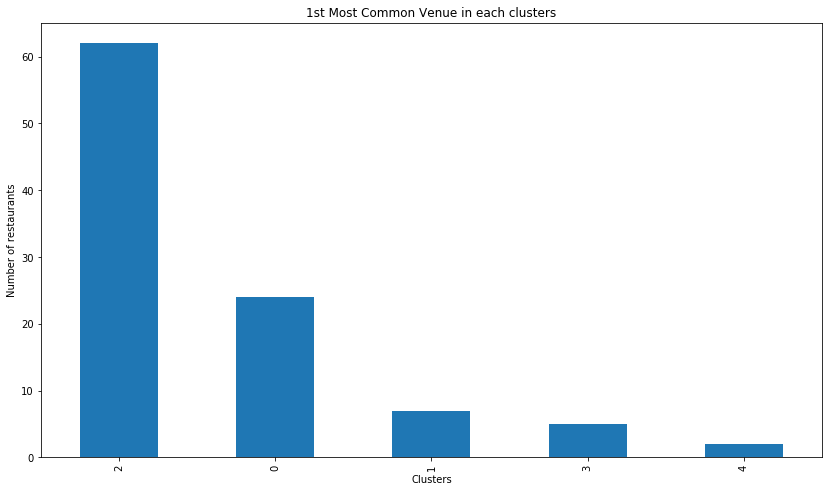

In [67]:
ax = berlin_merged['Cluster Labels'].value_counts().plot(kind='bar', figsize=(14,8), title="1st Most Common Venue in each clusters")
ax.set_xlabel("Clusters")
ax.set_ylabel("Number of restaurants")

I calculated the score of the available places to rent to the Japanese restaurants that already exists and to the public transportation. The lower score more optimal is the place. The results are showed in the figure below. 

Text(0, 0.5, 'Score [m]')

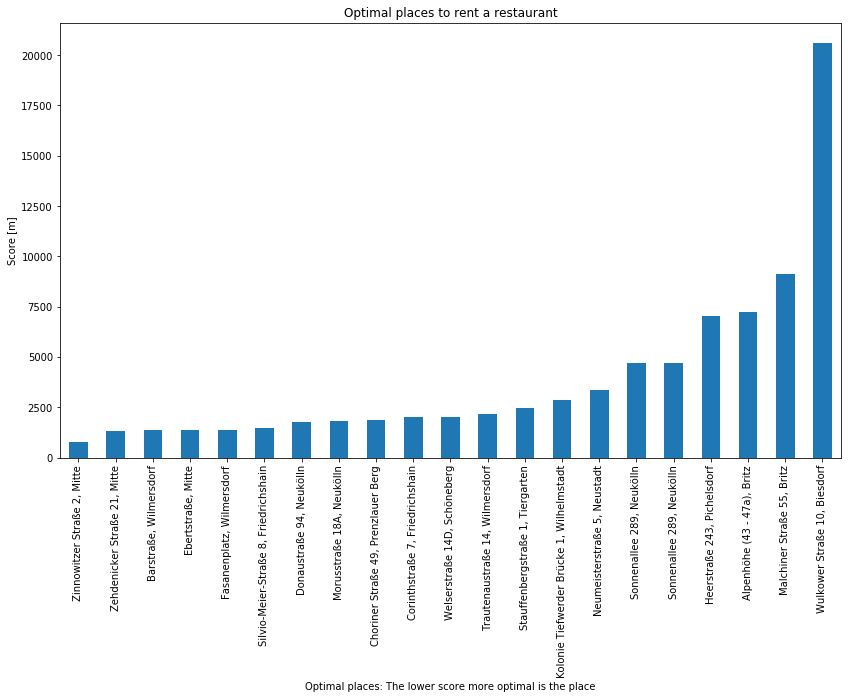

In [68]:
ax = df_r['Score'].plot(kind='bar', figsize=(14,8), title="Optimal places to rent a restaurant")
ax.set_xlabel("Optimal places: The lower score more optimal is the place")
ax.set_ylabel("Score [m]")

I will explore the results now using the `Folium map`. In the Berlin map below is showing the locations of each cluster and each type of the restaurant. Is also showing in the figure the optimal places (yellow points) with the score label in each point and includding the public transportation, the city train - s-bahn (green points) and the metro - U-bahn (blue points).

In [69]:
#berlin_map = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=10)
# create map
map_clusters = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

places_rent = folium.map.FeatureGroup()

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(berlin_merged['lat'], berlin_merged['lng'],berlin_merged['categories'], berlin_merged['Cluster Labels'] ):
    label = folium.Popup('Cluster ' + str(cluster) +': ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
# add markers to map
for lat, lng, label in zip(df_r['Latitude'], df_r['Longitude'], df_r['Score'] ):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(label),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
    
# add markers to map
for lat, lng, name in zip(df_s['lat'], df_s['lng'], df_s['name']):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(name),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.1,
        parse_html=False).add_to(map_clusters) 
    
    # add markers to map
for lat, lng, name in zip(df_u['lat'], df_u['lng'], df_u['name']):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(name),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.1,
        parse_html=False).add_to(map_clusters) 

map_clusters

In [70]:
map_clusters.save('map_clusters.html')

In [71]:
map_clusters.save('map_clusters.png')

Could be interesting to increase the dataset with avaiable places. Here it was used only one agency website to collect the data of avaiable places in Berlin. 

## 6. Conclusions <a name="Results and discussions"></a>

In this data science project, I showed how to explore venues using Fousquare API and how to get latitudes and longitudes using Geocoder. I chose the Japanese restaurant category to explore Foursquare venues in the city of Berlin. 

I applied the Machine Learning algorithm K-means Clustering and I made segmentations of the types of Japanese restaurants. Therefore, It was possible to observe in the `Folium map` the locations of the restaurants in each of the cluster created. 

I collected prices of avaiable places for opening a restaurant in Berlin and created a dataset. 

I calculated the score for locations that have a distance of approximately 300 m from Japanese restaurants that already exists and from public transportations, such as, the city train and the metro of Berlin. At the end, I obtained the results of the secret places to open a restaurant in Berlin.